### Importing libraries

In [1]:
import math
import pprint
import datetime
import numpy as np
import pandas as pd
from dateutil import parser
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pandas.tseries.offsets import BDay

In [2]:
%matplotlib inline

### Global variables

In [3]:
DATA_DIR = '../data'
IS_BUSINESS_DAY = BDay().is_on_offset

STARTING_VAULT_AMOUNT = 2000
PP = pprint.PrettyPrinter(depth=6)

### Reading and basic preprocessing of data

In [4]:
raw_xau_usd = pd.read_csv(f'{DATA_DIR}/^XAU_16Y.csv')

print('Shape is ({}, {})'.format(*raw_xau_usd.shape))
raw_xau_usd.head()

Shape is (4210, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-01-02,108.879997,110.510002,108.820000,109.480003,109.480003,8150000.0
1,2004-01-05,111.400002,113.180000,111.400002,112.879997,112.879997,13730000.0
2,2004-01-06,113.379997,113.410004,110.050003,110.639999,110.639999,17940000.0
3,2004-01-07,110.529999,110.540001,107.820000,108.300003,108.300003,16660000.0
4,2004-01-08,108.750000,109.930000,107.470001,108.970001,108.970001,16340000.0


In [7]:
raw_usd_cny = pd.read_csv(f'{DATA_DIR}/CAD_USD_16Y.csv')

print('Shape is ({}, {})'.format(*raw_usd_cny.shape))
raw_usd_cny.head()

Shape is (4365, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-01-01,0.770891,0.780457,0.770891,0.771605,0.771605,0.0
1,2004-01-02,0.772618,0.777484,0.770416,0.773694,0.773694,0.0
2,2004-01-05,0.777303,0.782901,0.775855,0.780518,0.780518,0.0
3,2004-01-06,0.780762,0.783331,0.776880,0.777242,0.777242,0.0
4,2004-01-07,0.777122,0.778755,0.773874,0.775494,0.775494,0.0


In [8]:
# This will merge both df according to their "Date" column and will
# fill nan in case a date is present in one and absent in other dataframe.
raw_df = raw_xau_usd.merge(raw_usd_cny, how='outer', left_on='Date', right_on='Date', suffixes=('_a', '_b'))

raw_df['Date'] = pd.to_datetime(raw_df['Date'])
raw_df = raw_df.loc[:, ['Date', 'Adj Close_a', 'Adj Close_b']]
raw_df.columns = ['Date', 'Price_A', 'Price_B']

print('Shape is ({}, {})'.format(*raw_df.shape))
print('Are null values present: {}'.format(raw_df.isna().values.any()))

raw_df.head()

Shape is (4365, 3)
Are null values present: True


,Date,Price_A,Price_B
0,2004-01-02,109.480003,0.773694
1,2004-01-05,112.879997,0.780518
2,2004-01-06,110.639999,0.777242
3,2004-01-07,108.300003,0.775494
4,2004-01-08,108.970001,0.782044


In [9]:
# Will replace the nan values with the last valid observation for that column.
raw_df = raw_df.ffill(axis=0).sort_values(by='Date').reset_index(drop=True)

print('Shape is ({}, {})'.format(*raw_df.shape))
print('Are null values present: {}'.format(raw_df.isna().values.any()))

raw_df.head()

Shape is (4365, 3)
Are null values present: False


,Date,Price_A,Price_B
0,2004-01-01,145.539993,0.771605
1,2004-01-02,109.480003,0.773694
2,2004-01-05,112.879997,0.780518
3,2004-01-06,110.639999,0.777242
4,2004-01-07,108.300003,0.775494


### Select Data

In [10]:
start_date = pd.Timestamp('today').floor('D') + pd.Timedelta(-3* 365, unit='D') 
end_date = pd.Timestamp('today').floor('D') + pd.Timedelta(-1 * 365, unit='D')

df = raw_df[
        (raw_df['Date']>=start_date) & (raw_df['Date']<=end_date)
     ].sort_values(by='Date').reset_index(drop=True)

### Artificial data

In [34]:
def plot_results (plot_data):
    gs = gridspec.GridSpec(5, 2)

    pl.figure(figsize=(8, 8))
    pl.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=1)

    ax = pl.subplot(gs[0,:]) # row 0, col 0
    plt.title('A Price')
    plt.plot(plot_data['dates'], plot_data['a_price'], color='blue')

    ax = pl.subplot(gs[1, 0]) # row 0, col 1
    plt.title('A buying power')
    plt.plot(plot_data['dates'], plot_data['a_buying_power'], color='blue')

    ax = pl.subplot(gs[1, 1]) # row 0, col 1
    plt.title('A held quantity')
    plt.plot(plot_data['dates'], plot_data['a'], color='blue')

    ax = pl.subplot(gs[2,:]) # row 0, col 0
    plt.title('B Price')
    plt.plot(plot_data['dates'], plot_data['b_price'], color='blue')

    ax = pl.subplot(gs[3, 0]) # row 0, col 1
    plt.title('B buying power')
    plt.plot(plot_data['dates'], plot_data['b_buying_power'], color='blue')

    ax = pl.subplot(gs[3, 1]) # row 0, col 1
    plt.title('B held quantity')
    plt.plot(plot_data['dates'], plot_data['b'], color='blue')

    ax = pl.subplot(gs[4, 0]) # row 1, span all columns
    plt.title('Valut Buying Power')
    plt.plot(plot_data['dates'], plot_data['vault_buying_power'], color='blue')
    
    ax = pl.subplot(gs[4, 1]) # row 1, span all columns
    plt.title('Valut Value')
    plt.plot(plot_data['dates'], plot_data['vault'], color='blue')

In [37]:
def simulate_model_with_same_bp(df, ratio_a=0.5, ratio_b=0.5, starting_amount=2000, slippage=0.05,
                                sell_apr_percentage = 0.01, rebalance_interval_days=7, sell_till_percentage=0.5):
    a_prev = df.iloc[0, 1]
    b_prev = df.iloc[0, 2]
    
    slippage_multiplier = (1 - slippage)
    counter = 0
    
    plot_data = {
        'dates': [],
        'vault': [],
        'vault_buying_power': [],
        'a': [],
        'b': [],
        'a_price': [],
        'b_price': [],
        'a_buying_power': [],
        'b_buying_power': []
    }
    
    START_CONFIG = {
        'vault': 0,
        'vault_buying_power': starting_amount,
        'a': 0,
        'b': 0,
        'a_buying_power': ratio_a * starting_amount,
        'b_buying_power': ratio_b * starting_amount
    }

    START_CONFIG['a'] = START_CONFIG.get('a_buying_power', 1000) / a_prev
    START_CONFIG['b'] = START_CONFIG.get('b_buying_power', 1000) / b_prev
    START_CONFIG['vault'] = START_CONFIG.get('b') +  START_CONFIG['a']
    
    min_balance_allowed_a = sell_till_percentage * START_CONFIG['a']
    min_balance_allowed_b = sell_till_percentage * START_CONFIG['b']
    
    print('Start with values')
    PP.pprint(START_CONFIG)
    print()
    
    for i in df.index.to_list():
        a = df.iloc[i, 1]
        b = df.iloc[i, 2]

        # calculate old buying power
        old_a_buying_power = START_CONFIG['a_buying_power']
        old_b_buying_power = START_CONFIG['b_buying_power']
        old_buying_power = old_a_buying_power + old_b_buying_power
        
        # calculate new buying power
        new_a_balance = START_CONFIG['a']
        new_b_balance = START_CONFIG['b']
        new_a_buying_power = new_a_balance * a
        new_b_buying_power = new_b_balance * b
        
        # check if the new buygin power has increased; only in which case do we rebalance
        new_buying_power = (new_a_buying_power + new_b_buying_power) 
        
        # now the target buying power should be something that maintains the ratio we 
        # have above.
        target_buying_power = new_buying_power * ratio_a + new_buying_power * ratio_b
        
        START_CONFIG['a_buying_power'] = target_buying_power
        START_CONFIG['b_buying_power'] = target_buying_power

        # caclulate the change in buying powr
        diff_a_b_buying_power = abs(new_a_buying_power - new_b_buying_power)
        
        # Rebalance the assets.       
        if (new_a_buying_power < new_b_buying_power):
            # if A has more buying power then we sell `sell_apr_percentage`% of the profits in A and buy B
            new_a_balance -= diff_a_b_buying_power / a * slippage_multiplier * sell_apr_percentage
            new_b_balance += diff_a_b_buying_power / b * slippage_multiplier * sell_apr_percentage
        else:
            # and vice versa
            new_a_balance += diff_a_b_buying_power / a * slippage_multiplier * sell_apr_percentage
            new_b_balance -= diff_a_b_buying_power / b * slippage_multiplier * sell_apr_percentage
        
        if (new_a_balance <= min_balance_allowed_a or new_b_balance <= min_balance_allowed_b):
            plot_data['dates'].append(df.loc[i, 'Date'])
            plot_data['vault'].append(START_CONFIG['a'] + START_CONFIG['b'])
            plot_data['vault_buying_power'].append(new_buying_power)
            plot_data['a'].append(START_CONFIG['a'])
            plot_data['b'].append(START_CONFIG['b'])
            plot_data['a_price'].append(a)
            plot_data['b_price'].append(b)
            plot_data['a_buying_power'].append(new_a_buying_power)
            plot_data['b_buying_power'].append(new_b_buying_power)
            continue
            
        # don't do anything if there is no change in the buying power or if we sell assets or if the quantity 
        # one of the underlying goes to 0. Ideally we should make sure that we buy/sell as much so that the
        # underlying does not get fully sold off.
        if i % rebalance_interval_days != 0 or (new_buying_power < old_buying_power) or new_a_balance <= 0 or new_b_balance <= 0:
            plot_data['dates'].append(df.loc[i, 'Date'])
            plot_data['vault'].append(START_CONFIG['a'] + START_CONFIG['b'])
            plot_data['vault_buying_power'].append(new_buying_power)
            plot_data['a'].append(START_CONFIG['a'])
            plot_data['b'].append(START_CONFIG['b'])
            plot_data['a_price'].append(a)
            plot_data['b_price'].append(b)
            plot_data['a_buying_power'].append(new_a_buying_power)
            plot_data['b_buying_power'].append(new_b_buying_power)
            continue

        counter += 1
            
        # Recalculate the vault balance.
        START_CONFIG['a'] = new_a_balance
        START_CONFIG['b'] = new_b_balance
        START_CONFIG['vault_buying_power'] = START_CONFIG.get('a_buying_power') + START_CONFIG.get('b_buying_power')
        
        plot_data['dates'].append(df.loc[i, 'Date'])
        plot_data['vault'].append(START_CONFIG['a'] + START_CONFIG['b'])
        plot_data['vault_buying_power'].append(START_CONFIG['vault_buying_power'])
        plot_data['a'].append(START_CONFIG['a'])
        plot_data['b'].append(START_CONFIG['b'])
        plot_data['a_price'].append(a)
        plot_data['b_price'].append(b)
        plot_data['a_buying_power'].append(new_a_buying_power)
        plot_data['b_buying_power'].append(new_b_buying_power)

        
        if (START_CONFIG['vault_buying_power'] - starting_amount) / starting_amount <= -0.3: 
            print('Breaking')
            break

        a_prev, b_prev = a, b
        
    print("finished with %d rebalances" % counter)
    print("final buying power of the vault is %d" % (new_a_buying_power + new_b_buying_power))
        
    return plot_data, START_CONFIG

Start with values
{'a': 6.870963639526904,
 'a_buying_power': 1000.0,
 'b': 1295.9998963200082,
 'b_buying_power': 1000.0,
 'vault': 1302.8708599595352,
 'vault_buying_power': 2000}

finished with 1 rebalances
final buying power of the vault is 1970

Ending with values
{'a': 6.870963639526904,
 'a_buying_power': 1970.5756183539506,
 'b': 1295.9998963200082,
 'b_buying_power': 1970.5756183539506,
 'vault': 1302.8708599595352,
 'vault_buying_power': 4000.0}



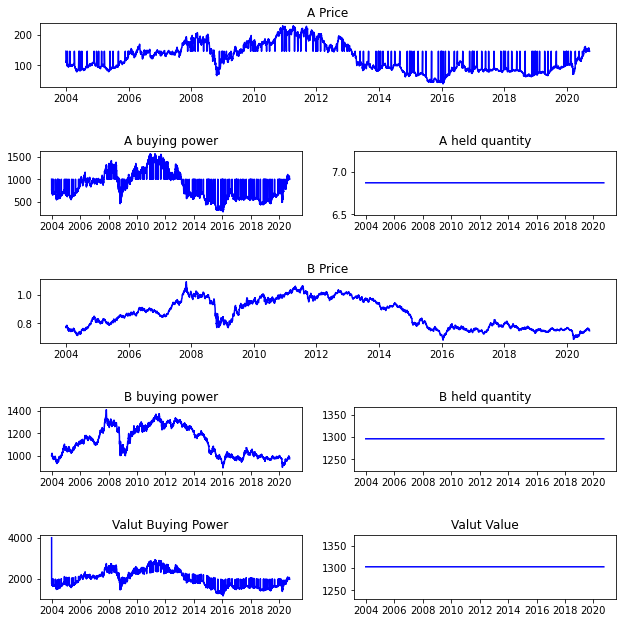

In [38]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 7 day rebalance interval
results, config = simulate_model_with_same_bp(
    raw_df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=7
    
)

print()
print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

Start with values
{'a': 6.870963639526904,
 'a_buying_power': 1000.0,
 'b': 1295.9998963200082,
 'b_buying_power': 1000.0,
 'vault_buying_power': 2000}

finished with 1 rebalances
final buying power of the vault is 1970

Ending with values
{'a': 6.870963639526904,
 'a_buying_power': 1970.5756183539506,
 'b': 1295.9998963200082,
 'b_buying_power': 1970.5756183539506,
 'vault_buying_power': 4000.0}



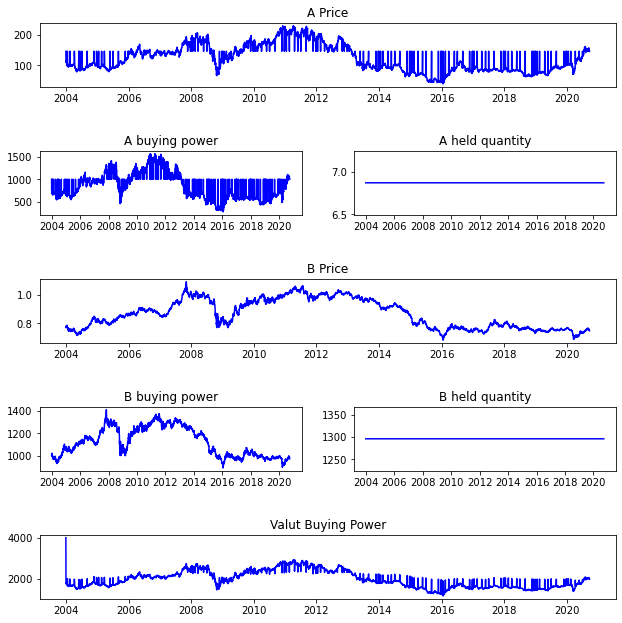

In [29]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 1 day rebalance interval
results, config = simulate_model_with_same_bp(
    raw_df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=1
)

print()
print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

# eventually we run out of one side of asset because we rebalance too much; 
# so we should ideally avoid this scenario..

Start with values
{'a': 6.870963639526904,
 'a_buying_power': 1000.0,
 'b': 1295.9998963200082,
 'b_buying_power': 1000.0,
 'vault_buying_power': 2000}

finished with 1 rebalances
final buying power of the vault is 1970


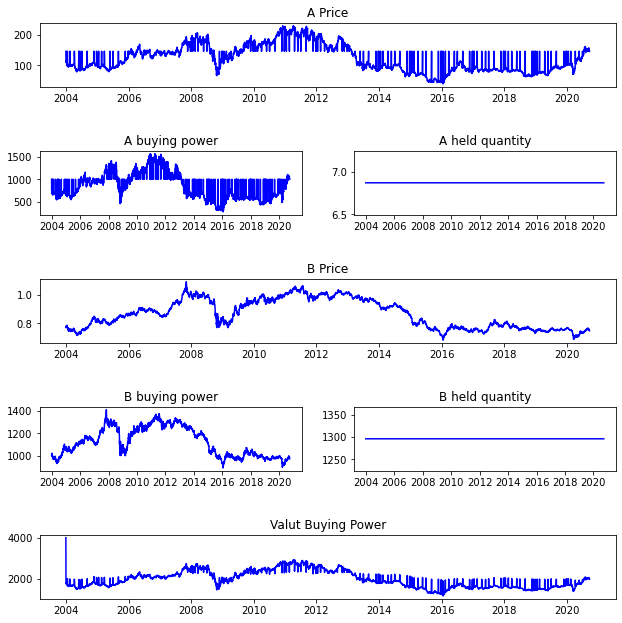

In [30]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 1 day rebalance interval; but selling 50% of 
# the appreciated side instead of 1%
results, config = simulate_model_with_same_bp(
    raw_df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=1,
    sell_apr_percentage=0.5
)

plot_results(results)

# eventually we run out of one side of asset because we sell too much; 
# so we should ideally avoid this scenario..

Start with values
{'a': 6.870963639526904,
 'a_buying_power': 1000.0,
 'b': 1295.9998963200082,
 'b_buying_power': 1000.0,
 'vault_buying_power': 2000}

finished with 1 rebalances
final buying power of the vault is 1970


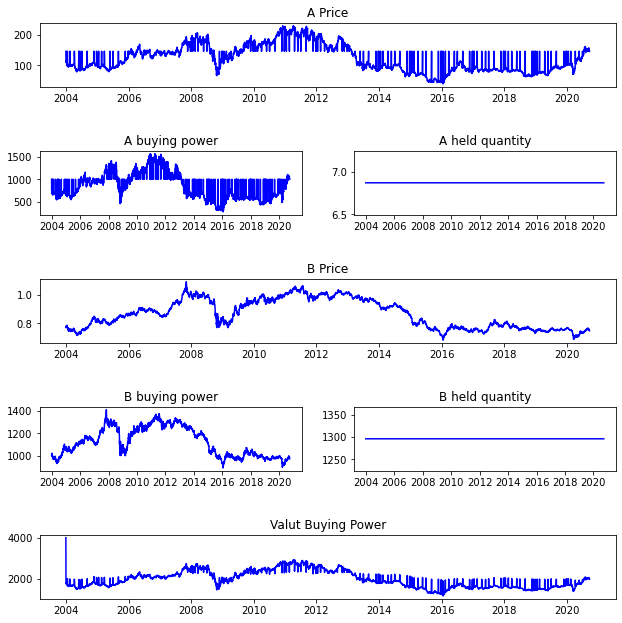

In [31]:
# USD and GOLD with a 50-50 ratio with no rebalancing
results, config = simulate_model_with_same_bp(
    raw_df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    sell_apr_percentage=0
)

plot_results(results)

### TODO

In [ ]:
# With one appreciating asset and one depreciating asset. The net result is on the positive.
results, config = simulate_model_with_same_bp(
    appreciating_asset,
    depreciating_asset,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT
)

plot_results(results)

In [ ]:
# With two depreciating assets. Really nothing we can do here. the
# net loss in the vault is the averaged loss; Which shows the importance of
# choosing two assets that are hedges of each other...

results, config = simulate_model_with_same_bp(
    depreciating_asset,
    depreciating_asset,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT
)

plot_results(results)